In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/kornelro/cv_project.git

Cloning into 'cv_project'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 213 (delta 113), reused 149 (delta 49), pack-reused 0
Receiving objects: 100% (213/213), 26.52 MiB | 7.03 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [ ]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=12904 sha256=f559351b57dd31992d401ff1794e9f2e1c1ebda7de01258d74986574fc11437e
  Stored in directory: /tmp/pip-ephem-wheel-cache-jlhqvitg/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src


In [ ]:
from src.data.make_dataset import make_dataset
from src.data.dataset_loaders import AerialCarsDatasetLoader
from src.data.image_loaders import AerialCarsFixedSizeImageLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage
from src.features.descriptors import HOGDescriptor, LBPDescriptor
from src.models.detectors import SliderDetector, NNSliderDetector
from src.data.sliders import SlidingWindow

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from copy import deepcopy
import time
import matplotlib.pyplot as plt
import random
from datetime import datetime
import tensorflow as tf
import tensorflow.keras as K
import numpy as np

In [ ]:
BND_BOX_SIZE = (128, 128)
SLIDER_STEP_SIZE = 16
DATASET_PATH = './drive/MyDrive/cv_project_data/data/raw/aerial-cars-dataset/'
VAL_DATASET_PATH = './drive/MyDrive/cv_project_data/data/raw/aerial-cars-dataset/val/'
WORKERS = 0

In [ ]:
dataset_loader = AerialCarsDatasetLoader(
    image_loader=AerialCarsFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        NormImage()
    ]
)

In [ ]:
start_time = time.time()

data = make_dataset(
    input_folder_filepath=DATASET_PATH,
    output_filepath='output_path',
    dataset_loader=dataset_loader,
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    process_pipeline=process_pipeline,
    negative_images_size=BND_BOX_SIZE,
    negative_examples_size=0.3,
    workers=WORKERS,
    verbose=True
)

print()
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 1153/1153 [00:00<00:00, 3854.88it/s]


--- 29.067283630371094 seconds ---


In [ ]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

input_t = K.Input(shape=(X[0].shape))
res_model = K.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t
)

for layer in res_model.layers:
    layer.trainable = False

model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='softmax'))

model.compile(optimizer=K.optimizers.Adam(0.01),
            loss=K.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=100,
            epochs=5, 
            validation_data=(X_test, y_test)
)

94674944/94668760 [==============================] - 5s 0us/step
Epoch 1/5
11/11 [==============================] - 2s 181ms/step - loss: 4.7858 - accuracy: 0.9007 - val_loss: 6.4828 - val_accuracy: 0.9483
Epoch 2/5
11/11 [==============================] - 1s 61ms/step - loss: 1.1591 - accuracy: 0.9855 - val_loss: 4.8104 - val_accuracy: 0.9741
Epoch 3/5
11/11 [==============================] - 1s 61ms/step - loss: 0.2390 - accuracy: 0.9961 - val_loss: 4.0246 - val_accuracy: 0.9828
Epoch 4/5
11/11 [==============================] - 1s 60ms/step - loss: 0.0134 - accuracy: 0.9990 - val_loss: 3.9837 - val_accuracy: 0.9828
Epoch 5/5
11/11 [==============================] - 1s 61ms/step - loss: 0.0313 - accuracy: 0.9981 - val_loss: 4.1108 - val_accuracy: 0.9741


In [ ]:
images = dataset_loader.load_dataset(
    input_folder_filepath=VAL_DATASET_PATH,
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    verbose=True
)

100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


In [ ]:
class ModelWrapper:

    def __init__(self, model):
        self.model = model

    def predict(self, images):
        results = []
        batches = np.array_split(images, round(len(images)/1000))
        for batch in batches:
            batch = np.stack(batch, 0)
            print(batch.shape)
            preds = self.model.predict(batch)
            for pred in preds:
                results.append(np.argmax(pred))
        return results

In [ ]:
sliding_window = SlidingWindow(
    step_size=SLIDER_STEP_SIZE,
    window_size=BND_BOX_SIZE
)

slider_detector = NNSliderDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ModelWrapper(model)
)

In [ ]:
data = None

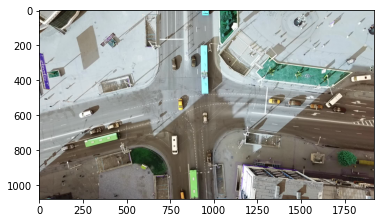

In [ ]:
plt.imshow(images[0].image)

In [ ]:
start_time = time.time()

(image, bnd_boxes) = slider_detector(deepcopy(images[0]), WORKERS, True)

print()
print("--- %s seconds ---" % (time.time() - start_time))

(1020, 128, 128, 3)
(1020, 128, 128, 3)
(1020, 128, 128, 3)
(1020, 128, 128, 3)
(1020, 128, 128, 3)
(1020, 128, 128, 3)
(1020, 128, 128, 3)
(1020, 128, 128, 3)

--- 30.966206312179565 seconds ---


In [ ]:
len(bnd_boxes)

127

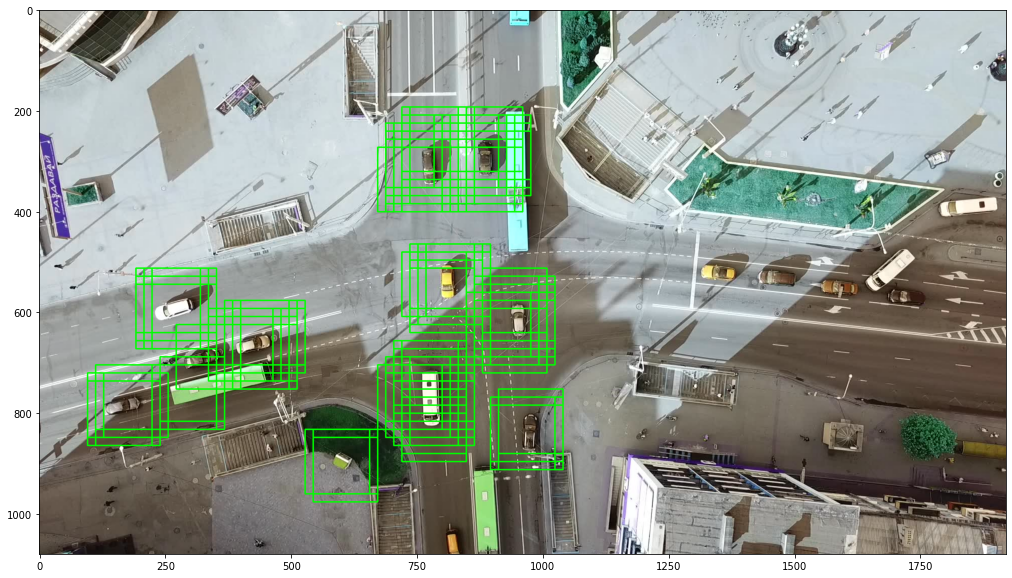

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.savefig('./2-4-detection-'+datetime.now().strftime("%d_%m_%Y_%H_%M_%S")+'.jpg')